In [1]:
import os, sys
import importlib
import torch

import numpy as np

from utils import load_torch, load

In [2]:
importlib.reload(load_torch)

data_folder = "data/simplified/"
access_file_generator = map(lambda x : data_folder + x + '.csv', load.classes)
trainGenerator = load_torch.ImageLoader(load.classes_1, data_folder)

In [3]:
gen = trainGenerator.__iter__()

In [4]:
%matplotlib inline
X, y = next(gen)
print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: torch.Size([16, 1, 32, 32])
y.shape: torch.Size([16])


# Building PyTorch CNN Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim


class VanillaDoodle(nn.Module):
    # Here we define our network structure
    name="doodle-vanilla"
    def __init__(self, cdim=8):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3).double() 
        self.conv2 = nn.Conv2d(6,16, 3).double()
        self.conv3 = nn.Conv2d(16,32,3).double()
        self.conv4 = nn.Conv2d(32,64,3).double()
        self.fc1   = nn.Linear(128,120).double()
        self.fc2   = nn.Linear(120, 84).double() 
        self.fc3   = nn.Linear(84,cdim).double()
        
    # Here we define one forward pass through the network
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = x.view(-1, int(self.num_flat_features(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x): 
        size = x.size()
        return np.prod(size[1:])


#net = VanillaDoodle(cdim=len(load.classes_1))

In [6]:
# Code derived from: https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class InceptionModule(nn.Module):

    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 12, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 24, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(24, 24, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(24, 24, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 32, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(32, 24, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(24, 24, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(24, 24, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 16, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)
    
class DoodleInception(nn.Module):
    # Here we define our network structure
    name="doodle-inception"
    def __init__(self, cdim=8):
        super(DoodleInception, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3).double() 
        self.mod1  = InceptionModule(6).double()
        self.conv2 = nn.Conv2d(124, 128, 3).double()
        self.fc1   = nn.Linear(512,128).double()
        self.fc2   = nn.Linear(128,cdim).double()
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.mod1(x)), (2, 2))  #?x124x7x7
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))  #?x128x2x2
        x = x.view(-1, int(self.num_flat_features(x)))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x): 
        size = x.size()
        return np.prod(size[1:])

In [10]:
B     = 128              # Minibatch size
T     = 10               # Number of epochs
gamma = .001             # learning rate
rho   = .9               # momentum

classes = load.classes_1
    
net = DoodleInception(cdim=len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    net.parameters(),
    lr=gamma,
    momentum=rho
)

In [11]:
if torch.cuda.is_available():
    net = net.cuda()

trainingAcc = [0]
testingAcc  = [0]
trainingLoss = []
testingLoss = []
for epoch in range(T):            
    gen = load_torch.ImageLoader(classes=load.classes_1,root_location=data_folder,read_size=32,batch_size=150)
    for i, (images, labels) in enumerate(gen):

        vsplit = int(images.shape[0]*0.8)
        
        xtrain = images[:vsplit]
        ltrain = labels[:vsplit]
        
        xtest  = images[vsplit:]
        ltest  = labels[vsplit:]
        
        # Forward pass
        ypred = net(xtrain)
        loss = criterion(ypred.cpu(), ltrain)
        train_acc  = 100 * np.mean(ltrain.data.numpy() == ypred.cpu().data.numpy ().T.argmax(axis =0))
        train_loss = loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ypred = net(xtest)
        loss = criterion(ypred.cpu(), ltest)
        test_acc  = 100 * np.mean(ltest.data.numpy() == ypred.cpu().data.numpy ().T.argmax(axis =0))
        test_loss = loss.item()
        
        del images
        del labels
        del ypred

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}], Loss: {:.4f} (val:{:.4f}), Accuracy:{:.2f}% (val:{:.2f}%)' .format(epoch+1, T, i+1, train_loss, test_loss, train_acc, test_acc))
            #model.save_state_dict('mytraining.pt')
        if (i+1)%100==0:
            trainingAcc.append((0.1*train_acc) + (0.9*trainingAcc[-1]))
            trainingLoss.append(train_loss)
            testingAcc.append((0.1*test_acc) + (0.9*testingAcc[-1]))
            testingLoss.append(test_loss)

Epoch [1/10], Step [100], Loss: 1.9099 (val:1.8602), Accuracy:42.86% (val:31.82%)
Epoch [1/10], Step [200], Loss: 1.5013 (val:1.4432), Accuracy:47.62% (val:50.00%)
Epoch [1/10], Step [300], Loss: 1.4267 (val:1.8525), Accuracy:45.24% (val:31.82%)
Epoch [1/10], Step [400], Loss: 1.2769 (val:1.0461), Accuracy:53.57% (val:68.18%)
Epoch [1/10], Step [500], Loss: 1.3024 (val:1.1524), Accuracy:58.33% (val:59.09%)
Epoch [1/10], Step [600], Loss: 1.2524 (val:1.3044), Accuracy:58.33% (val:50.00%)
Epoch [1/10], Step [700], Loss: 0.7183 (val:1.1081), Accuracy:78.57% (val:63.64%)
Epoch [1/10], Step [800], Loss: 0.8711 (val:0.9694), Accuracy:69.05% (val:68.18%)
Epoch [1/10], Step [900], Loss: 0.8819 (val:0.7363), Accuracy:71.43% (val:77.27%)
Epoch [1/10], Step [1000], Loss: 1.0338 (val:1.4176), Accuracy:69.05% (val:68.18%)
Epoch [1/10], Step [1100], Loss: 0.7887 (val:0.7045), Accuracy:70.24% (val:90.91%)
Epoch [1/10], Step [1200], Loss: 0.7691 (val:0.7002), Accuracy:79.76% (val:81.82%)
Epoch [1/10],

Epoch [2/10], Step [2600], Loss: 0.3989 (val:0.3293), Accuracy:88.10% (val:90.91%)
Epoch [2/10], Step [2700], Loss: 0.2185 (val:0.6919), Accuracy:90.48% (val:68.18%)
Epoch [2/10], Step [2800], Loss: 0.3820 (val:0.5034), Accuracy:86.90% (val:81.82%)
Epoch [2/10], Step [2900], Loss: 0.3722 (val:0.4966), Accuracy:85.71% (val:86.36%)
Epoch [2/10], Step [3000], Loss: 0.3593 (val:0.2452), Accuracy:89.29% (val:90.91%)
Epoch [2/10], Step [3100], Loss: 0.4387 (val:0.4143), Accuracy:83.33% (val:86.36%)
Epoch [2/10], Step [3200], Loss: 0.4761 (val:0.5995), Accuracy:82.14% (val:86.36%)
Epoch [2/10], Step [3300], Loss: 0.3249 (val:1.0918), Accuracy:90.48% (val:59.09%)
Epoch [2/10], Step [3400], Loss: 0.3725 (val:0.4866), Accuracy:89.29% (val:86.36%)
Epoch [2/10], Step [3500], Loss: 0.5379 (val:0.2401), Accuracy:82.14% (val:100.00%)
Epoch [2/10], Step [3600], Loss: 0.3650 (val:0.3259), Accuracy:86.90% (val:95.45%)
Epoch [2/10], Step [3700], Loss: 0.4979 (val:0.4572), Accuracy:86.90% (val:90.91%)
Epo

Epoch [3/10], Step [5100], Loss: 0.4945 (val:0.3030), Accuracy:79.76% (val:86.36%)
Epoch [3/10], Step [5200], Loss: 0.2937 (val:0.2708), Accuracy:85.71% (val:81.82%)
Epoch [3/10], Step [5300], Loss: 0.3204 (val:0.3650), Accuracy:89.29% (val:86.36%)
Epoch [3/10], Step [5400], Loss: 0.1333 (val:0.1188), Accuracy:96.43% (val:95.45%)
Epoch [3/10], Step [5500], Loss: 0.3342 (val:0.7866), Accuracy:85.71% (val:77.27%)
Epoch [3/10], Step [5600], Loss: 0.2930 (val:0.1067), Accuracy:89.29% (val:100.00%)
Epoch [3/10], Step [5700], Loss: 0.2832 (val:0.2627), Accuracy:86.90% (val:86.36%)
Epoch [3/10], Step [5800], Loss: 0.3136 (val:0.1911), Accuracy:91.67% (val:90.91%)
Epoch [3/10], Step [5900], Loss: 0.5104 (val:0.1606), Accuracy:88.10% (val:100.00%)
Epoch [3/10], Step [6000], Loss: 0.3266 (val:0.6782), Accuracy:88.10% (val:77.27%)
Epoch [3/10], Step [6100], Loss: 0.4017 (val:0.2590), Accuracy:86.90% (val:95.45%)
Epoch [3/10], Step [6200], Loss: 0.2497 (val:0.1746), Accuracy:91.67% (val:100.00%)
E

Epoch [5/10], Step [200], Loss: 0.3352 (val:0.2167), Accuracy:90.48% (val:90.91%)
Epoch [5/10], Step [300], Loss: 0.3931 (val:0.5949), Accuracy:84.52% (val:81.82%)
Epoch [5/10], Step [400], Loss: 0.5070 (val:0.2054), Accuracy:83.33% (val:90.91%)
Epoch [5/10], Step [500], Loss: 0.3392 (val:0.3541), Accuracy:89.29% (val:86.36%)
Epoch [5/10], Step [600], Loss: 0.3439 (val:0.2492), Accuracy:90.48% (val:90.91%)
Epoch [5/10], Step [700], Loss: 0.1330 (val:0.0970), Accuracy:96.43% (val:100.00%)
Epoch [5/10], Step [800], Loss: 0.2389 (val:0.2953), Accuracy:91.67% (val:90.91%)
Epoch [5/10], Step [900], Loss: 0.1492 (val:0.5008), Accuracy:94.05% (val:90.91%)
Epoch [5/10], Step [1000], Loss: 0.4039 (val:0.6088), Accuracy:85.71% (val:77.27%)
Epoch [5/10], Step [1100], Loss: 0.2292 (val:0.3618), Accuracy:89.29% (val:86.36%)
Epoch [5/10], Step [1200], Loss: 0.2007 (val:0.5318), Accuracy:95.24% (val:90.91%)
Epoch [5/10], Step [1300], Loss: 0.2811 (val:0.2947), Accuracy:91.67% (val:86.36%)
Epoch [5/10

Epoch [6/10], Step [2700], Loss: 0.3746 (val:0.1973), Accuracy:89.29% (val:95.45%)
Epoch [6/10], Step [2800], Loss: 0.1751 (val:0.2244), Accuracy:95.24% (val:90.91%)
Epoch [6/10], Step [2900], Loss: 0.2216 (val:0.1334), Accuracy:92.86% (val:95.45%)
Epoch [6/10], Step [3000], Loss: 0.3704 (val:0.5401), Accuracy:88.10% (val:90.91%)
Epoch [6/10], Step [3100], Loss: 0.2613 (val:0.3933), Accuracy:91.67% (val:86.36%)
Epoch [6/10], Step [3200], Loss: 0.2700 (val:0.3436), Accuracy:90.48% (val:90.91%)
Epoch [6/10], Step [3300], Loss: 0.3319 (val:0.1400), Accuracy:86.90% (val:95.45%)
Epoch [6/10], Step [3400], Loss: 0.3295 (val:0.2689), Accuracy:89.29% (val:90.91%)
Epoch [6/10], Step [3500], Loss: 0.3447 (val:0.0650), Accuracy:86.90% (val:100.00%)
Epoch [6/10], Step [3600], Loss: 0.3152 (val:0.3395), Accuracy:88.10% (val:86.36%)
Epoch [6/10], Step [3700], Loss: 0.3000 (val:0.1138), Accuracy:88.10% (val:95.45%)
Epoch [6/10], Step [3800], Loss: 0.2327 (val:0.2116), Accuracy:91.67% (val:90.91%)
Epo

Epoch [7/10], Step [5200], Loss: 0.3417 (val:0.0341), Accuracy:91.67% (val:100.00%)
Epoch [7/10], Step [5300], Loss: 0.2831 (val:0.4000), Accuracy:91.67% (val:86.36%)
Epoch [7/10], Step [5400], Loss: 0.1279 (val:0.0740), Accuracy:98.81% (val:100.00%)
Epoch [7/10], Step [5500], Loss: 0.3104 (val:0.4402), Accuracy:90.48% (val:90.91%)
Epoch [7/10], Step [5600], Loss: 0.1979 (val:0.1731), Accuracy:94.05% (val:95.45%)
Epoch [7/10], Step [5700], Loss: 0.1418 (val:0.5866), Accuracy:95.24% (val:77.27%)
Epoch [7/10], Step [5800], Loss: 0.2613 (val:0.3463), Accuracy:89.29% (val:90.91%)
Epoch [7/10], Step [5900], Loss: 0.1733 (val:0.3480), Accuracy:94.05% (val:90.91%)
Epoch [7/10], Step [6000], Loss: 0.3888 (val:0.1486), Accuracy:92.86% (val:95.45%)
Epoch [7/10], Step [6100], Loss: 0.2448 (val:0.2449), Accuracy:91.67% (val:90.91%)
Epoch [7/10], Step [6200], Loss: 0.2052 (val:0.0350), Accuracy:94.05% (val:100.00%)
Epoch [7/10], Step [6300], Loss: 0.2100 (val:0.3735), Accuracy:94.05% (val:86.36%)
E

Epoch [9/10], Step [300], Loss: 0.3001 (val:0.2569), Accuracy:89.29% (val:95.45%)
Epoch [9/10], Step [400], Loss: 0.3678 (val:0.4395), Accuracy:89.29% (val:77.27%)
Epoch [9/10], Step [500], Loss: 0.2741 (val:0.0783), Accuracy:89.29% (val:100.00%)
Epoch [9/10], Step [600], Loss: 0.2592 (val:0.0452), Accuracy:92.86% (val:100.00%)
Epoch [9/10], Step [700], Loss: 0.2079 (val:0.1669), Accuracy:91.67% (val:95.45%)
Epoch [9/10], Step [800], Loss: 0.2886 (val:0.2645), Accuracy:90.48% (val:90.91%)
Epoch [9/10], Step [900], Loss: 0.3216 (val:0.1945), Accuracy:94.05% (val:95.45%)
Epoch [9/10], Step [1000], Loss: 0.2761 (val:0.2435), Accuracy:91.67% (val:90.91%)
Epoch [9/10], Step [1100], Loss: 0.2716 (val:0.2252), Accuracy:90.48% (val:95.45%)
Epoch [9/10], Step [1200], Loss: 0.3778 (val:0.0979), Accuracy:90.48% (val:95.45%)
Epoch [9/10], Step [1300], Loss: 0.2331 (val:0.3481), Accuracy:95.24% (val:86.36%)
Epoch [9/10], Step [1400], Loss: 0.2595 (val:0.1995), Accuracy:92.86% (val:95.45%)
Epoch [9/

Epoch [10/10], Step [2800], Loss: 0.1616 (val:0.2180), Accuracy:94.05% (val:90.91%)
Epoch [10/10], Step [2900], Loss: 0.1948 (val:0.0641), Accuracy:92.86% (val:95.45%)
Epoch [10/10], Step [3000], Loss: 0.3882 (val:0.4722), Accuracy:89.29% (val:86.36%)
Epoch [10/10], Step [3100], Loss: 0.3711 (val:0.4269), Accuracy:86.90% (val:86.36%)
Epoch [10/10], Step [3200], Loss: 0.3019 (val:0.3968), Accuracy:91.67% (val:90.91%)
Epoch [10/10], Step [3300], Loss: 0.1613 (val:0.1063), Accuracy:95.24% (val:95.45%)
Epoch [10/10], Step [3400], Loss: 0.5301 (val:0.2774), Accuracy:86.90% (val:90.91%)
Epoch [10/10], Step [3500], Loss: 0.2488 (val:0.1429), Accuracy:91.67% (val:95.45%)
Epoch [10/10], Step [3600], Loss: 0.2558 (val:0.1682), Accuracy:89.29% (val:95.45%)
Epoch [10/10], Step [3700], Loss: 0.3212 (val:0.2511), Accuracy:89.29% (val:90.91%)
Epoch [10/10], Step [3800], Loss: 0.2364 (val:0.4262), Accuracy:92.86% (val:86.36%)
Epoch [10/10], Step [3900], Loss: 0.4448 (val:0.3688), Accuracy:88.10% (val:

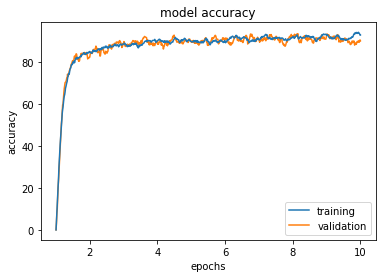

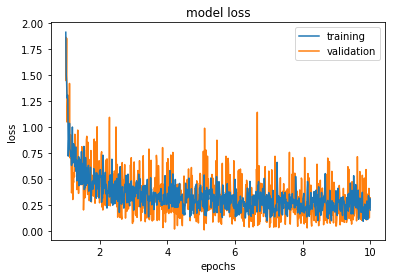

Final training acc:  91.98%
Final training loss: 0.2533
Final testing acc:   90.41%
Final testing loss:  0.2736


In [29]:
import matplotlib.pyplot as plt

x = np.linspace(1,T,len(trainingAcc))
plt.plot(x,trainingAcc, label="training", zorder=5)
plt.plot(x,testingAcc, label="validation", zorder=0)
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title("model accuracy")
plt.legend(loc="best")
plt.savefig("Graphs/{0}-{1}classes-acc.png".format(net.name, len(classes)))
plt.show()
plt.close()

x = np.linspace(1,T,len(trainingLoss))
plt.plot(x,trainingLoss, label="training", zorder=5)
plt.plot(x,testingLoss, label="validation", zorder=0)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("model loss")
plt.legend(loc="best")
plt.savefig("Graphs/{0}-{1}classes-loss.png".format(net.name, len(classes)))
plt.show()
plt.close()

accdata = (len(testingAcc) - 1)//10
lossdata = (len(testingLoss))//10
print("Final training acc:  {:.2f}%".format(np.mean(trainingAcc[-accdata:])))
print("Final training loss: {:.4f}".format(np.mean(trainingLoss[-lossdata:])))
print("Final testing acc:   {:.2f}%".format(np.mean(testingAcc[-accdata:])))
print("Final testing loss:  {:.4f}".format(np.mean(testingLoss[-lossdata:])))

In [26]:
help(np.linspace)

Help on function linspace in module numpy.core.function_base:

linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
    Return evenly spaced numbers over a specified interval.
    
    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].
    
    The endpoint of the interval can optionally be excluded.
    
    Parameters
    ----------
    start : scalar
        The starting value of the sequence.
    stop : scalar
        The end value of the sequence, unless `endpoint` is set to False.
        In that case, the sequence consists of all but the last of ``num + 1``
        evenly spaced samples, so that `stop` is excluded.  Note that the step
        size changes when `endpoint` is False.
    num : int, optional
        Number of samples to generate. Default is 50. Must be non-negative.
    endpoint : bool, optional
        If True, `stop` is the last sample. Otherwise, it is not included.
        Default is True.
    retstep : bo

90.41457248047058